Aquí vamos a sacar las gráficas del efecto Mpemba, que va a ser mucho más fácil a la hora de editar las gráficas.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import qutip as q
import random as random
import time

## Modelo de all-to-all interacting spins

Definimos todas las funciones

In [2]:
# Funcion que, dado un vector y su dimension, me genera una base de vectores ortonormales en la cual este mismo vector es el primero
def generar_base_ortonormal(vector, dim):
    # Normalizar el primer vector
    v1 = vector / np.linalg.norm(vector)
    v1 = np.squeeze(np.asarray(v1, dtype = complex))
    # Generar una matriz aleatoria de dimensión (dim x dim)
    random_matrix = np.matrix(np.random.randn(dim, dim), dtype = complex)

    # Realizar el proceso de Gram-Schmidt para generar los vectores ortogonales restantes
    base = [v1]
    for i in range(1, dim):
        # Obtener el siguiente vector aleatorio
        #v = np.reshape(random_matrix[i], (1, max(random_matrix[i].shape)))
        v = np.squeeze(np.asarray(random_matrix[i], dtype = complex))
        #v = np.asarray(random_matrix[i], dtype = complex)
        #v = np.reshape(v, (1, max(v.shape)))
        # Restar las proyecciones de los vectores anteriores
        for j in range(i):
            v -= np.dot(v, base[j].T) * base[j]

        # Normalizar el vector resultante
        v /= np.linalg.norm(v)

        # Agregar el vector a la base ortonormal
        base.append(v)

    return base


# Funcion que me obtiene el hamiltoniano del modelo de atomos de rydberg
def rydberg(N, params):
    omega = params[0]
    delta = params[1]
    v = params[2]
    k = params[3]
    j = N/2
    
    Sx = q.jmat(j, 'x')
    Sz = q.jmat(j, 'z')
    Sm = q.jmat(j, '-')
    
    H = omega*Sx
    #H = omega*Sx - delta*Sz + (v/N)*Sz*Sz
    J = np.sqrt(k/N)*Sm
    
    return H, J

def densidad(N):
    return q.basis(int(N+1), 0)*(q.basis(int(N+1), 0)).dag(), q.basis(int(N+1), 0)

# Funcion que me hace lo de Mpemba1 pero con qutip
def Mpemba1_mejorada_q(L, L_e, autovals, d, N, ini):

  # Se obtiene el segundo autovalor con la parte real mayor
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(autovals)))

  # Hacemos reshape
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  vals = todo[0]
  vects = todo[1]
  #vects = [elemento.full() for elemento in todo[1]]
  """
  todo = (sp.Matrix(L1, dtype = complex)).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  vects = [np.reshape(elemento, (1, max(elemento.shape))) for elemento in vects]
  vals = list(np.array(vals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(vals)

  # Ahora, generamos la base auxiliar para el vector ini
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux= [q.Qobj(x) for x in base_aux]
  #base_aux = np.asarray([elemento for elemento in base_aux], dtype = complex)
  U_cambio = vects[0]*(base_aux[0].dag())
  #U_cambio = ketbra((vects[0]), base_aux[0])
  for i in range(1, N):
      U_cambio += vects[i]*(base_aux[i].dag())
    #U_cambio += ketbra((vects[i]), base_aux[i])

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  #tol = 1.0e-14
  es_cero = [(np.allclose(np.abs(vals[i]), 0.0, atol = 1e-5)) for i in range(len(vals))]

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    #print(vals[indice])
    #print(vals[indice])
    print(vals[indice])
    #U = ketbra(ini, vects[indice][0])
    U = ini*(vects[indice].dag())
    #U = ini*(vects[indice].dag())
    #U = ketbra(ini, vects[indice])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  #return q.Qobj(U), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio
    


# Funcion que nos calcula la transformacion de Mpemba2, pero con qutip
def Mpemba2_mejorada_q(L, L_e, vals, d, N, ini):
   # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  
  # segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(vals)))
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo([np.real(elemento) for elemento in vals])
  #print('Autovalores', vals)
  #print('Segundo maximo', segundo_maximo)
  #indice_segundo_maximo = vals.index(segundo_maximo)
  #print('Indice segundo maximo: ' + str(indice_segundo_maximo))
  L_buenos= []
  for elemento in L_e:
      if(np.allclose(L*elemento, np.zeros_like(L*elemento), atol = 1e-2) == False):
          L_buenos.append(elemento)
  # La pasamos a matriz
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_buenos[0], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  #L1 = sp.Matrix(L1, dtype = complex)
  #print('Autovalor asociado al l1: ', L1)

  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  autovals = todo[0]
  autovects = todo[1]
  #autovects = [elemento.full() for elemento in todo[1]]
  """
  todo = L1.eigenvects()
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  autovals = list(np.array(autovals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(autovals)

  # Ahora, generamos la base auxiliar para el vector estado inicial
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux = [q.Qobj(x) for x in base_aux]
  #print('Dimension: ', base_aux[2].shape)
  #base_aux = np.array([elemento for elemento in base_aux], dtype = complex)
  
  # Con esto, podemos generar la primera transformacion
  U_cambio = autovects[0]*base_aux[0].dag()
  #U_cambio = ketbra(autovects[0], base_aux[0])
  for i in range(1, N):
      U_cambio += autovects[i]*(base_aux[i].dag())
      
  #es_cero = [(np.isclose(np.abs(autovals[i]), 0, atol = 1e-4)) for i in range(len(autovals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  #indice_contrario = 0
  #indice_inicial = es_cero.index(False)
  #print(indice_inicial)
  #autovals = eliminar_duplicados(autovals)
  #es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(np.real(autovals[0])*np.real(autovals[-1]) < 0):
    #indice_contrario = es_contrario.index(True)
    #print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = autovects[0]*autovects[-1].dag() + autovects[-1]*autovects[0].dag()
    #F = autovects[indice_inicial]*autovects[indice_contrario].dag() + autovects[indice_contrario]*autovects[indice_inicial].dag()
    #F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[0]))/(np.abs(autovals[-1]))))
    #s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    #print((autovals[indice_inicial], autovals[indice_contrario]))
    #print(F)
    #identidad = kronecker(iden, 0, N)
    identidad = q.qeye(F.shape[0])
    U = identidad + (np.cos(s) - 1.0)*(F*F) - 1.j*np.sin(s)*F
    #U = identidad + (np.cos(s) - 1.0)*(np.dot(np.conjugate(F.T), F)) - 1.j*np.sin(s)*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio, (autovals[0], autovals[-1])
  #return q.Qobj(U), U_cambio, (autovals[0], autovals[-1])
    
# Funcion que me genera una base ortonormal en la cual esta incluido un vector que yo le paso
def generar_base_ortonormal_q(vector):
    # Convertir el vector a un objeto Qobj
    vector_qobj = q.Qobj(vector)

    # Normalizar el vector
    vector_normalizado = vector_qobj.unit()

    # Definir el primer vector de la base como el vector normalizado
    base = [vector_normalizado]

    # Generar los vectores restantes de la base utilizando Gram-Schmidt
    for i in range(len(vector.full())):
        if i == 0:
            continue
        # Proyectar el vector original sobre los vectores de la base ya generados
        proyecciones = [vector_normalizado.overlap(v) * v for v in base]
        # Restar las proyecciones del vector original para ortogonalizarlo
        vector_ortogonalizado = vector_qobj - sum(proyecciones)
        # Normalizar el vector ortogonalizado para obtener un nuevo vector de la base
        #vector_normalizado = vector_ortogonalizado.unit()
        vector_normalizado = vector_ortogonalizado
        # Agregar el nuevo vector a la base
        base.append(vector_normalizado)
    
    #base = [elemento.unit() for elemento in base]
    return base

def densidad_bueno(N):
    M = 2 # Numero de fotones
    #M = 8
    j = N/2.0
    n = 2*j + 1
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #print(np.allclose(spin_operator(N, 'z')[0], q.jmat(2*j, 'z')))
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    Jz = q.jmat(j, 'z')
    print(Jz.shape)
    # Creamos la base de autoestados de sz
    todo = Jz.eigenstates(sparse = True, sort = 'high')
    base = todo[1]
    #base = [elemento.full() for elemento in todo[1]]
    #base = [np.array(tup[2], dtype = complex) for tup in todo]
    #base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
    #print(base)

    # Construimos el vector inicial
    a, b = random.random(), random.random()
    ini = (a + b*1.j)*base[0]
    for i in range(1, len(base)):
      a, b = random.random(), random.random()
      ini += (a + b*1.j)*base[i]
    # Le hacemos el ketbra para construir la matriz densidad

    ini = ini.unit()
    d = ini*ini.dag()
    #d = ketbra(ini, ini)
    #res = d/(np.linalg.norm(d))
    return d, ini

def dicke_bueno(N, params):
    M = 2
    #M = 8
    j = N/2.0
    n = 2*j + 1
    Jz = q.jmat(j, 'z')
    Jx = q.jmat(j, 'x')
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    #Jx = q.tensor(q.qeye(M), q.jmat(j, 'x'))
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #Jx = q.tensor(q.qeye(M), spin_operator(N, 'x')[0])
    
    sigma = params[0]
    w = params[1]
    k = params[2]
    g = params[3]
    
    H = sigma*Jz
    #H = sigma*Jz - ((4.0*w*g*g)/(4.0*w**2 + k**2))*(1.0/N)*Jx*Jx
    J = ((2.0*np.abs(g)*np.sqrt(k))/(np.sqrt(N*(4*w*w + k*k))))*Jx
    #J = -((np.sqrt(k)*g*(4*w + 2*1.j*k))/(np.sqrt(N)*(4*w*w + k*k)))*Jx
    return H, J

def kronecker(matriz, pos, n):
  ide = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  #res = np.zeros((int(2**n), int(2**n)))
  if(pos == 0):
    res = matriz
  else:
    res = ide

  for i in range(1, n):
    if(i == pos):
      res = np.kron(res, matriz)
    else:
      res = np.kron(res, ide)
  return res

def H_eff(H, saltos):
  suma = np.zeros((H.shape[0], H.shape[1]), dtype = complex)
  for salto in saltos:
    suma += np.matrix(np.dot(np.conjugate(salto.T), salto), dtype = complex)
  Heff = H - 0.5*(1.j)*suma
  return Heff

# Funcion que calcula las nuevas probabilidades de salto y de no salto
def Calcularp(d, V):
  return np.trace(np.dot(np.dot(V, d), np.conjugate(V.T)))

# Funcion que nos calcula el nuevo estado tras un salto de tiempo
def NuevoEstado(d, V, H):
  return (np.dot(np.dot(V, d), (np.conjugate(V.T))))/(np.sqrt(np.trace(np.dot(np.dot(V, d), (np.conjugate(V.T))))))

# Funcion que resuelve el sistema mediante el metodo de montecarlo
def ResolverSistema(d0, H, salto, N, nveces):
  # Establecemos un limite de tiempo
  t = 0.0
  limite = 80.0
  tiempo = [t]
  dt = 0.01

  vector_fotones = []
  nfotones = 0 # numero de fotones
  res = [d0]
  # Hamiltoniano efectivo
  Heff = H_eff(H, salto)

  # Operadores de evolución y de salto del sistema
  V = [np.sqrt(dt)*J for J in salto]
  V_0 = np.eye(int(N+1)) - 1.j*dt*Heff

  intentos = [] #Aqui guardamos todos los resultados para cada realizacion

  # Calculamos las probabilides iniciales
  p0 = Calcularp(d0, V_0)
  p = Calcularp(d0, V[0])
  d = d0
  # Empezamos con el bucle
  while(t < limite):
    prob = random.random()
    if(prob < p):
      nfotones += 1
      d = NuevoEstado(d, V[0], H)
    else:
      d = NuevoEstado(d, V_0, H)
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    res.append(d)
    t += dt
    tiempo.append(t)

  vector_fotones.append(nfotones)
  intentos.append(res)
  # Ahora, hacemos el bucle otras nveces-1 veces para luego promediar
  indice = 1
  while(indice < nveces):
    d = d0
    nfotones = 0
    res = [d0]
    t = 0.0
    # Calculamos las probabilidades iniciales
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    while(t < limite):
      prob = random.random()
      if(prob < p):
        nfotones += 1
        d = NuevoEstado(d, V[0], H)
      else:
        d = NuevoEstado(d, V_0, H)
      p0 = Calcularp(d, V_0)
      p = Calcularp(d, V[0])
      res.append(d)
      t += dt
    intentos.append(res)
    indice += 1
    vector_fotones.append(nfotones)

  # Por último calculamos el promedio de las trayectorias
  suma = [0 for i in range(len(intentos[0]))]
  for i in range(len(intentos[0])):
    for elemento in intentos:
      suma[i] += elemento[i]
  final = [elemento/nveces for elemento in suma]
  return final, tiempo, vector_fotones

In [20]:
inicio = time.time()

# Parámetros del sistema
N = 40 # Número de átomos
omega = 1 # Frecuencia de transición de los átomos
delta = -1.0*omega  # Frecuencia del modo del campo electromagnético
v = 3.0*omega  # Constante de acoplamiento átomo-modo
kappa = 1*omega
params = [omega, delta, v, kappa]


# Hamiltoniano del sistema y operador de salto
H, J = rydberg(N, params)

d0, ini = densidad_bueno(N)
#d0, ini = rydberg.densidad(N)
psi0 = ini
print(H.shape)
#d0 = Qobj(d0)

# Lista de tiempos de la simulación
tlist = np.linspace(0, 2000, 5000)

# Sacamos el lindbladiano y sus autovalores
L = q.liouvillian(H, [J])
todoh = (L.dag()).eigenstates(sparse = True, sort = 'high', eigvals = N + 20)
todo = L.eigenstates(sparse = True, sort = 'high', eigvals = N + 20)
vals = todoh[0]
vects = todoh[1]
r = [q.Qobj(np.reshape(x, (N+1, N+1))) for x in todo[1]]
l = [q.Qobj(np.reshape(x, (N+1, N+1))) for x in todoh[1]]


# Efecto Mpemba
U1 = Mpemba1_mejorada_q(L, vects, vals, d0, N, ini)[0]
U2, U_cambio, vals_l = Mpemba2_mejorada_q(L, vects, vals, d0, N, ini)
U_cambio = q.Qobj(U_cambio)

ini1 = np.dot(U1.full(), ini.full())
ini2 = np.dot(U2.full(), ini.full())
d01 = np.dot(np.dot(U1.full(), d0.full()), (U1.dag()).full())
d02 = np.dot(np.dot(U2.full(), d0.full()), (U2.dag()).full())
print(H.shape)

veces = 50
# Integramos la ecuación maestra
options = q.Options(nsteps = 1e4)
output1 = q.mesolve(H, U_cambio*q.Qobj(d0)*U_cambio.dag(), tlist, [J], options=options)
output2 = q.mesolve(q.Qobj(H.full()), q.Qobj(d01), tlist, [q.Qobj(J.full())], options=options)
output3 = q.mesolve(q.Qobj(H.full()), q.Qobj(d02), tlist, [q.Qobj(J.full())], options=options)

(41, 41)
(41, 41)
Se puede hacer la vía del cero, con el autovalor: 
(-3.4762094056026355e-15+1.4635038147510342e-15j)
Vamos a probar la via del no cero
La s me sale: 0.7853981633974466 se ha cogido la s que sale de los autovalores: 
(41, 41)


In [21]:
# Obtenemos las trayectorias cuánticas
"""
output1_traj = ResolverSistema(d0.full(), H.full(), [J.full()], N, veces)
output2_traj = ResolverSistema(d01, H.full(), [J.full()], N, veces)
output3_traj = ResolverSistema(d02, H.full(), [J.full()], N, veces)
"""
"""
output1 = general.solucion(d0, r, l, vals, tlist)
output2 = general.solucion(q.Qobj(d01), r, l, vals, tlist)
output3 = general.solucion(q.Qobj(d02), r, l, vals, tlist)
"""
est = q.steadystate(q.Qobj(H), [q.Qobj(J)])
vector1, vector2, vector3 = [], [], []

for i in range(len(output1.states)):
    x1 = output1.states[i] - est
    x2 = output2.states[i] - q.Qobj(est.full())
    x3 = output3.states[i] - q.Qobj(est.full())
    vector1.append(np.sqrt(np.trace(x1.dag()*x1)))
    vector2.append(np.sqrt(np.trace(x2.dag()*x2)))
    vector3.append(np.sqrt(np.trace(x3.dag()*x3)))

"""
vector1_traj, vector2_traj, vector3_traj = [], [], []
for i in range(len(output1_traj)):
    x1 = q.Qobj(output1_traj[i] - est[i])
    #x2 = q.Qobj(output2_traj[i] - est[i])
    x3 = q.Qobj(output3_traj[i] - est[i])
    
    vector1_traj.append(np.sqrt(np.trace(x1.dag()*x1)))
    #vector2_traj.append(np.sqrt(np.trace(x2.dag()*x2)))
    vector3_traj.append(np.sqrt(np.trace(x3.dag()*x3)))
"""
fin = time.time()
print('Tiempo: ' + str(fin-inicio))

Tiempo: 1555.262895822525


In [ ]:
j = N/2
sz = q.jmat(j, 'z')
vector1, vector2, vector3 = [], [], []
for i in range(len(output1.states)):
    x1 = output1.states[i]
    x2 = output2.states[i]
    x3 = output3.states[i]
    
    x1_q = sz*x1*sz
    x2_q = sz*x2*sz
    x3_q = sz*x3*sz
    
    vector1.append(-np.log((x1_q.dag()*x1_q).tr()) + np.log(((x1.dag())*x1).tr()))
    vector2.append(-np.log((x2_q.dag()*x2_q).tr()) + np.log(((x2.dag())*x2).tr()))
    vector3.append(-np.log((x3_q.dag()*x3_q).tr()) + np.log(((x3.dag())*x3).tr()))

In [ ]:
len(vector1)

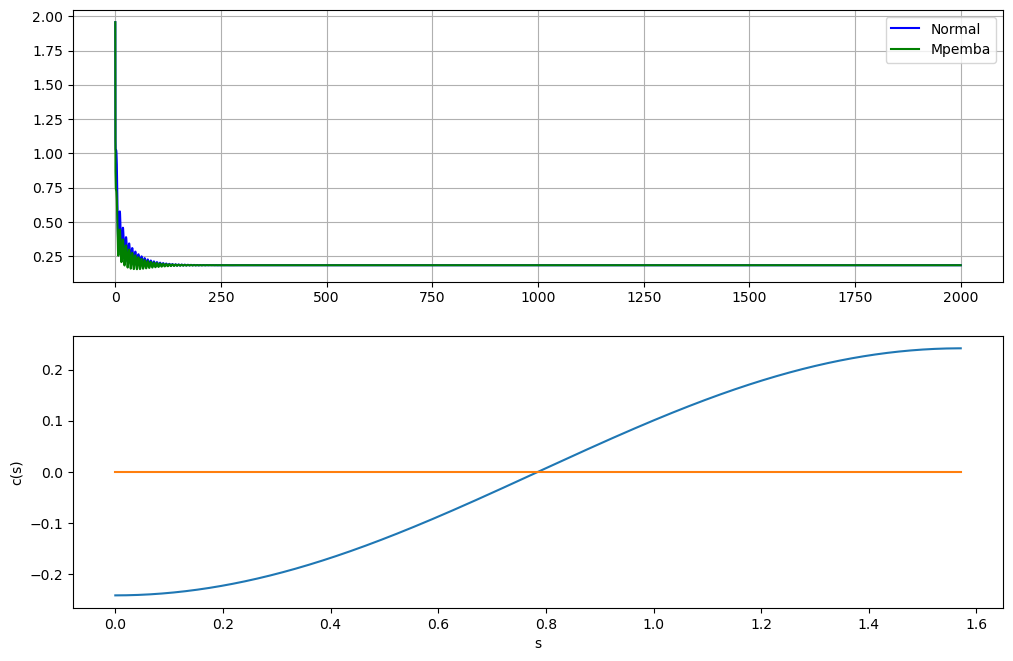

In [22]:
fig = plt.figure(figsize = (12, 12))

# Parte distancias
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tlist, vector1, 'b-', label = 'Normal')
#ax1.plot(tlist, vector2, 'r.-', label = 'Mpemba 1')
ax1.plot(tlist, vector3, 'g-', label = 'Mpemba')
#ax1.plot(tlist, vector1_traj, 'b.', label = 'Normal traj')
#ax1.plot(tlist, vector3_traj, 'g.', label = 'Mpemba traj')
#ax1.set_xlim(0.0, 10)

ax1.grid(True)
ax1.legend()

# Parte esfera
ax2 = fig.add_subplot(3, 1, 2)

s = np.linspace(0, np.pi*0.5, 1000)
c_s = vals_l[0]*np.cos(s)**2 + vals_l[1]*np.sin(s)**2
ax2.plot(s, c_s)
ax2.plot(s, np.zeros_like(c_s))

ax2.set_xlabel('s')
ax2.set_ylabel('c(s)')

plt.show()

## Modelo de Dicke

In [8]:
inicio = time.time()

# Parámetros del sistema
N = 40 # Número de átomos
omega_a = 1 # Frecuencia de transición de los átomos
omega = 1.0*omega_a  # Frecuencia del modo del campo electromagnético
g = 1.0*omega_a  # Constante de acoplamiento átomo-modo
#g = np.sqrt(16)*np.sqrt(omega_a)
kappa = 1*omega_a
params = [omega_a, omega, kappa, g]

# Hamiltoniano del sistema
H, J = dicke_bueno(N, params)

# Estado inicial
d0a, inia = densidad_bueno(N)
d0b, inib = densidad_bueno(N)
d0 = 0.4*d0a + 0.6*d0b
ini = 0.4*inia + 0.6*inib
psi0 = ini
print(H.shape)

# Lista de tiempos de la simulación
tlist = np.linspace(0, 100, 1000)

# Sacamos el lindbladiano y sus autovalores
L = q.liouvillian(H, [J])
todoh = (L.dag()).eigenstates(sparse = True, sort = 'high', eigvals = N+3)

vals = todoh[0]
vects = todoh[1]

# Efecto Mpemba
U1 = Mpemba1_mejorada_q(L, vects, vals, d0, N, ini)[0]
U2, U_cambio, vals_l = Mpemba2_mejorada_q(L, vects, vals, d0, N, ini)
U_cambio = q.Qobj(U_cambio)
# Resolver la ecuación maestra para obtener la evolución temporal del sistema
print(d0.shape)
ini1 = np.dot(U1.full(), ini.full())
ini2 = np.dot(U2.full(), ini.full())
#d01 = np.dot(np.dot(U1.full(), d0.full()), (U1.dag()).full())
#d02 = np.dot(np.dot(U2.full(), d0.full()), (U2.dag()).full())
d01 = U1*d0*U1.dag()
d02 = U2*d0*U2.dag()
print(ini1.shape == ini.shape)
print(H.shape)
output1 = q.mesolve(H, U_cambio*q.Qobj(d0)*U_cambio.dag(), tlist, [J])
output2 = q.mesolve(q.Qobj(H.full()), q.Qobj(d01), tlist, [q.Qobj(J.full())])
output3 = q.mesolve(q.Qobj(H.full()), q.Qobj(d02), tlist, [q.Qobj(J.full())])

est = q.steadystate(q.Qobj(H), [q.Qobj(J)])
vector1, vector2, vector3, vector4 = [], [], [], []
for i in range(len(output1.states)):
    x1 = output1.states[i] - est
    x2 = output2.states[i] - q.Qobj(est.full())
    x3 = output3.states[i] - q.Qobj(est.full())
    vector1.append(np.sqrt(np.trace(x1*x1)))
    vector2.append(np.sqrt(np.trace(x2*x2)))
    vector3.append(np.sqrt(np.trace(x3*x3)))

fin = time.time()
print('Tiempo: ' + str(fin-inicio))

(41, 41)
(41, 41)
(41, 41)
No se ha podido hacer la via del cero
Vamos a probar la via del no cero
La s me sale: 0.874261891390827 se ha cogido la s que sale de los autovalores: 
(41, 41)
True
(41, 41)
Tiempo: 1106.1801018714905


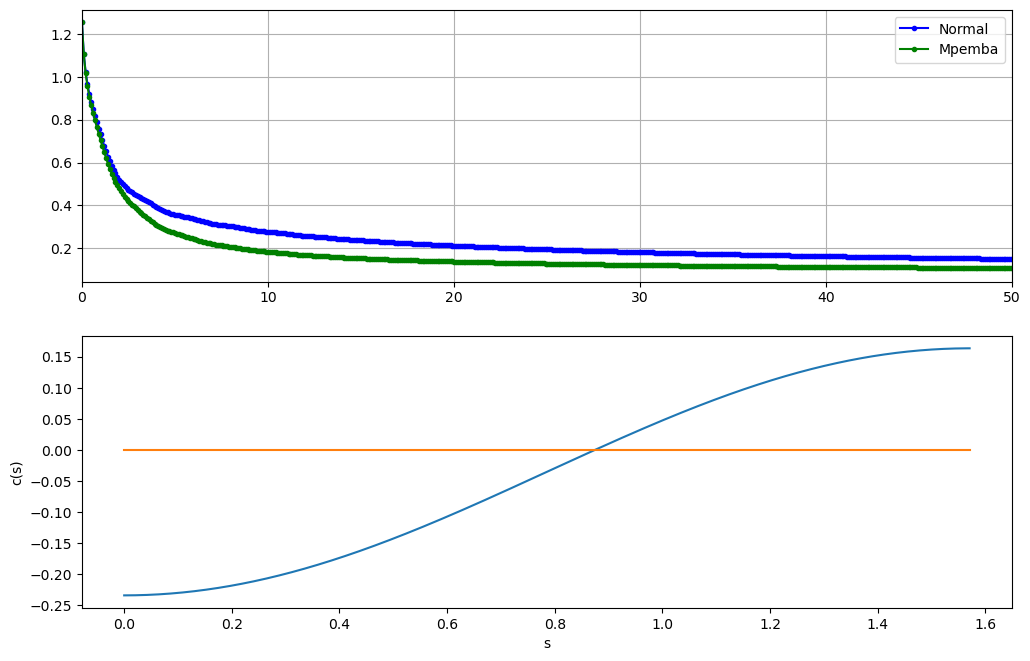

In [9]:
fig = plt.figure(figsize = (12, 12))

# Parte distancias
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tlist, vector1, 'b.-', label = 'Normal')
#ax1.plot(tlist, vector2, 'r.-', label = 'Mpemba 1')
ax1.plot(tlist, vector3, 'g.-', label = 'Mpemba')

ax1.grid(True)
ax1.legend()
ax1.set_xlim(0.0, 50)

#ax1.set_title('Distancia de H-S. Dicke. g = ' + str(g))

# Parte esfera
ax2 = fig.add_subplot(3, 1, 2)

s = np.linspace(0, np.pi*0.5, 1000)
c_s = vals_l[0]*np.cos(s)**2 + vals_l[1]*np.sin(s)**2
ax2.plot(s, c_s)
ax2.plot(s, np.zeros_like(c_s))

ax2.set_xlabel('s')
ax2.set_ylabel('c(s)')

plt.show()

## Lo de las condiciones iniciales

In [6]:
def densidad_p(N, inicial, final):
    j = N/2.0
    n = 2*j + 1
    Jz = q.jmat(j, 'z')
    todo = Jz.eigenstates(sparse = False, sort = 'high')
    base = todo[1]
    
    a, b = inicial + (final-inicial)*random.random(), inicial + (final-inicial)*random.random()
    ini = (a + b*1.j)*base[0]
    for i in range(1, len(base)):
        a, b = inicial + (final-inicial)*random.random(), inicial + (final-inicial)*random.random()
        ini += (a + b*1.j)*base[i]
    
    ini = ini.unit()
    d = ini*ini.dag()
    return d, ini

In [11]:
inicio = time.time()

# Parámetros del sistema
N = 40 # Número de átomos
omega_a = 1 # Frecuencia de transición de los átomos
omega = 1.0*omega_a  # Frecuencia del modo del campo electromagnético
g = 1.0*omega_a  # Constante de acoplamiento átomo-modo
#g = np.sqrt(16)*np.sqrt(omega_a)
kappa = 1*omega_a
params = [omega_a, omega, kappa, g]

# Hamiltoniano del sistema
H, J = dicke_bueno(N, params)

L = q.liouvillian(H, [J])
todoh = (L.dag()).eigenstates(sparse = True, sort = 'high', eigvals = N+3)

vals = todoh[0]
vects = todoh[1]

l1 = q.Qobj(np.reshape(vects[1], (H.shape[0], H.shape[1])))

In [13]:
#p = 5.0
vectorp = np.linspace(-5.0, 5-0, 25)
res = []
veces = 100
for p in vectorp:
    traza = 0.0
    print(p)
    for i in range(veces):
        d, ini = densidad_p(N, 0.0-p, 1.0 + p)
        traza += (l1*d).tr()
    res.append(traza/veces)
final = time.time()
print(final-inicio)

-5.0
-4.583333333333333
-4.166666666666667
-3.75
-3.333333333333333
-2.9166666666666665
-2.5
-2.083333333333333
-1.6666666666666665
-1.25
-0.833333333333333
-0.4166666666666661
0.0
0.41666666666666696
0.8333333333333339
1.25
1.666666666666667
2.083333333333334
2.5
2.916666666666667
3.333333333333334
3.75
4.166666666666668
4.583333333333334
5.0
8245.355842351913


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


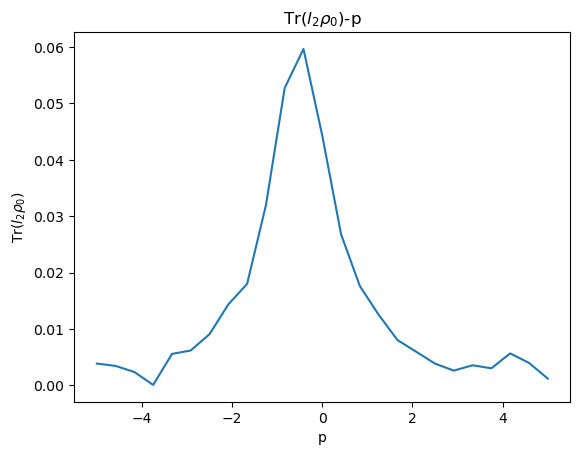

In [14]:
plt.title(r'Tr($l_2$$\rho_0$)-p')
plt.xlabel('p')
plt.ylabel(r'Tr($l_2$$\rho_0$)')
plt.plot(vectorp, res)